In [1]:
library(magrittr)
library(tidyverse)
source("~/wisdom/r/clean_theme.R")
source("../data/env/variables.R")

options("readr.num_columns" = 0)

switches <- read_tsv("../results/supplementary_files/supplementary_file_1.tsv")

switches.split <- read_tsv("../data/pancancer/candidateList_full.tumorSplit.tsv") %>%
    filter(Origin=="Tumor")

cna_drivers <- read_tsv("../data/intogen_cancer_drivers-2014.12b/CNA_drivers_per_tumor_type.tsv", skip = 9) %>%
    rename(Symbol = geneHGNCsymbol,
           Tumor = Tumor_type_GISTIC,
           What = GISTIC_CNA) %>%
    select(Symbol, Tumor, What) %>%
    mutate(Tumor = ifelse(Tumor=="COREAD", "coad", Tumor),
           Tumor = ifelse(Tumor=="HC", "lihc", Tumor),
           Tumor = ifelse(Tumor=="RCCC", "kirc", Tumor),
           Tumor = tolower(Tumor) )

cna <- lapply(cancerTypes, function(tumor){
    read_tsv(paste0("../data/cnv/", tumor, "_gene_cnv-count_full.txt"), col_names = FALSE) %>%
        set_colnames(c("chr_gene","start_gene","end_gene","Gene","wut1","strand",
                       "chr","start","end","Patient","score","wut2")) %>%
        filter(score > log2(3/2) | score < log2(1/2)) %>%
        mutate(What = ifelse(score < log2(1/2), "D", "A")) %>%
        select(Gene, Patient, What) %>%
        unique %>%
        separate(Gene, into = c("Symbol", "GeneId"), sep = "\\|") %>%
        mutate(Tumor = tumor)
        
}) %>% do.call("rbind",.)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Warning message:
“654 parsing failures.
   row col   expected actual
 28086 X12 an integer      .
 62949 X12 an integer      .
161862 X12 an integer      .
205116 X12 an integer      .
211023 X12 an integer      .
...... ... .......... ......
See problems(...) for more details.
”Warning message:
“654 parsing failures.
  row col   expected actual
11878 X12 an integer      .
26992 X12 an integer      .
68545 X12 an integer      .
86680 X12 an integer      .
89278 X12 an integer      .
..... ... .......... ......
See problems(...) for more details.
”Warning message:
“654 parsing failures.
   row col   expected actual
 13669 X12 an integer      .
 30626 X12 an integer      .
 78791 X12 an integer      .
 99791 X12 

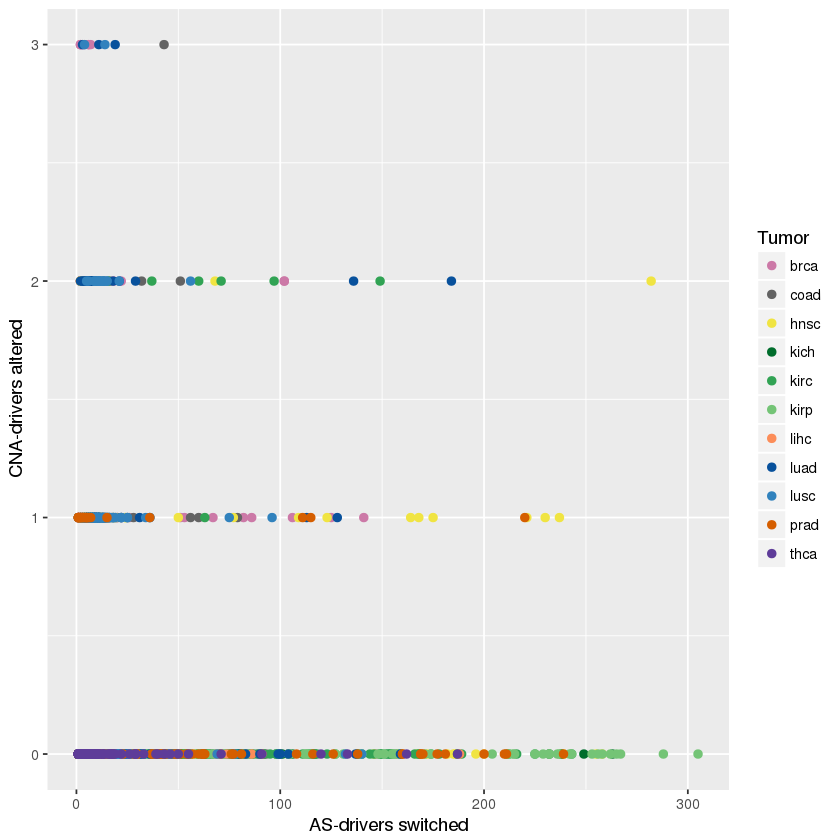

In [6]:
potus <- switches %>%
    filter(AS_driver==1) %>%
    select(GeneId,Symbol,Normal_transcript,Tumor_transcript)

# check that all the patients have at least one switch/mutation
alterationsPerPatient <- lapply(cancerTypes, function(tumor){
  
    # read switches
    tumor.potus <- switches.split %>%
        filter(Tumor==tumor) %>%
        merge(potus)
  
    ## count number of AS drivers switched per patient
    patients <- tumor.potus$Patients_affected %>% strsplit(",") %>% unlist
    switchesPerPatient <- plyr::count(patients) %>%
        set_colnames(c("Patient","Switches"))
  
    # read mutations  
    ## get cancer specific drivers
    tumor.cna_drivers <- cna_drivers$Symbol[cna_drivers$Tumor==tumor]
   
    ## filter out mutations not in drivers
    cna.cna_drivers <- cna  %>%
        merge(cna_drivers) %>%
        select(GeneId,Patient) %>%
        unique
    
    ## count number of mutations per patient
    cnaPerPatient <- plyr::count(cna.cna_drivers$Patient) %>%
        set_colnames(c("Patient","CNA"))
    
    # get patients with both RNAseq and mutation information
    patients.swt <- unique(patients)
    patients.cna <- unique(cna$Patient)
    patients.common <- intersect(patients.swt,patients.cna)
    
    merge(cnaPerPatient,switchesPerPatient, all=T) %>%
        mutate(Switches = ifelse(is.na(Switches), 0, Switches ),
               CNA = ifelse(is.na(CNA), 0, CNA),
               Tumor = tumor) %>%
        filter(Patient %in% patients.common)
  
}) %>% do.call("rbind",.)

ggplot(alterationsPerPatient,aes(x=Switches,y=CNA,color=Tumor)) + 
    geom_point(size=2) + 
    labs(x="AS-drivers switched",y="CNA-drivers altered") +
    scale_color_manual(values=colorPalette)